Notebook originally by [@alekseynp](https://gist.github.com/alekseynp/41f70c509176cbff765e79ebe5edaa6a)

# ReLUs - Any intuition as to why they work?

ReLU activations are certainly popular. Their gradients are well behaved and address the vanishing gradient problem. But, how does such a simple non-lineaerity actually allow us to fit highly non-linear functions?

In the notebook below I attempt to provide some simple examples that start to show this.

# Functions, Imports, Scaffolding for our experiments

In [1]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mlp
mlp.style.use('classic')

In [2]:
from keras.models import Model
from keras.layers import Input, Dense
import keras.optimizers

Using Theano backend.


In [3]:
def get_model(num_hidden_units):
    model_input = Input(shape=(1,), dtype='float32', name='input')
    net = Dense(num_hidden_units, activation='relu')(model_input)
    out = Dense(1, activation='linear')(net)

    model = Model(inputs=model_input, outputs=out)
    optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=optimizer)    
    return model

In [4]:
def poly_generator(coeffs, batch_size=320):
    output_x = np.zeros((batch_size))
    output_y = np.zeros((batch_size))
       
    while True:
        output_x = np.random.uniform(-1.0, 1.0, batch_size)
        output_y = np.polynomial.polynomial.polyval(output_x, coeffs)
        yield output_x, output_y

In [76]:
def train_a_model(num_hidden_units, coeffs):
    model = get_model(num_hidden_units)
    generator = poly_generator(coeffs)
    model.fit_generator(generator, steps_per_epoch=5000, epochs=1, verbose=0)
    return model

In [6]:
def train_models(coeffs):
    models = []
    for num_hidden_units in np.arange(1, 10):
        print('{0}'.format(num_hidden_units), end=', ')
        mod = train_a_model(num_hidden_units, coeffs)
        models.append(mod)
    return models

In [7]:
def plot_a_model(ax, model, coeffs):
    xs = np.arange(-1.0,1.0,0.01)
    ys = model.predict(xs).ravel()
    ys_true = np.polynomial.polynomial.polyval(xs, coeffs)

    ax.plot(xs, ys, label='Preds')
    ax.plot(xs, ys_true, label='Truth')

    # trying to highlight the kinks, maybe off by 1 or 2 positions, but that's fine
    delta = np.abs(ys[1:] - ys[:-1])
    ddelta = np.abs(delta[1:] - delta[:-1])
    idxes = np.argsort(ddelta)[-num_hidden_units:]
    ax.plot(xs[idxes], ys[idxes], 'o')

In [8]:
def plot_models(models, coeffs):
    assert len(models) == 9
    fig, axarr = plt.subplots(3, 3, figsize=(9,9))

    for i, ax in enumerate(np.ravel(axarr)):
        print('{0}'.format(i + 1), end=', ')
        mod = models[i]
        num_hidden_units = mod.layers[1].get_config()['units']
        plot_a_model(ax, mod, coeffs)
        ax.set_title('# hidden units: {}'.format(i+1))
    plt.tight_layout()

# Experiments

### Experiment 1 
Target function:
$$f(x) = 0.1 + 0.2x + 0.3x^2 + 0.4x^3$$

Model:
- Single layer neural network with between 1 and 9 hidden units

In [8]:
coeffs = [0.1, 0.2, 0.3, 0.4]

In [9]:
%time models = train_models(coeffs)

1, 2, 3, 4, 5, 6, 7, 8, 9, CPU times: user 16.8 s, sys: 555 ms, total: 17.4 s
Wall time: 53.2 s


1, 2, 3, 4, 5, 6, 7, 8, 9, 

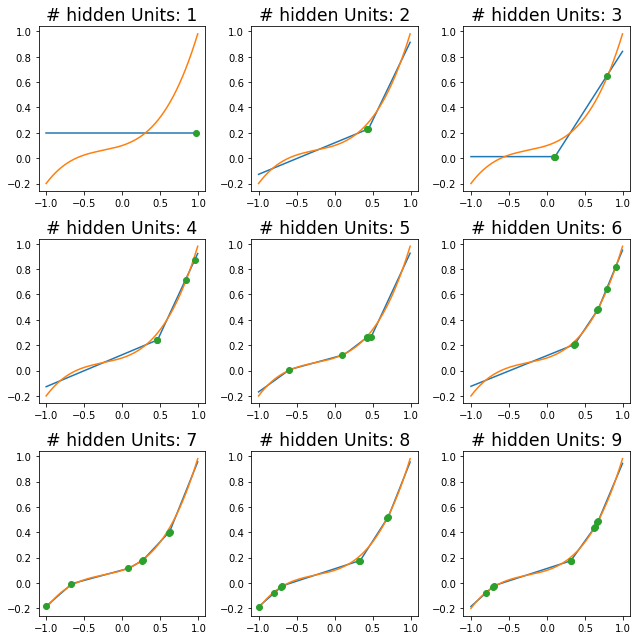

In [10]:
plot_models(models, coeffs)

circles highlight where the kinks are, it looks as the number of hidden neurons grow, the number of kinks increases, too, which hints a stacking effect of the ReLU hidden neurons.

### Experiment 2
Target function:
$$f(x) = x^2$$ 

Model:
- Single layer neural network with between 1 and 9 hidden units

In [13]:
coeffs = [0, 0, 1]

In [14]:
%time models = train_models(coeffs)

1, 2, 3, 4, 5, 6, 7, 8, 9, CPU times: user 16.2 s, sys: 274 ms, total: 16.5 s
Wall time: 51 s


1, 2, 3, 4, 5, 6, 7, 8, 9, 

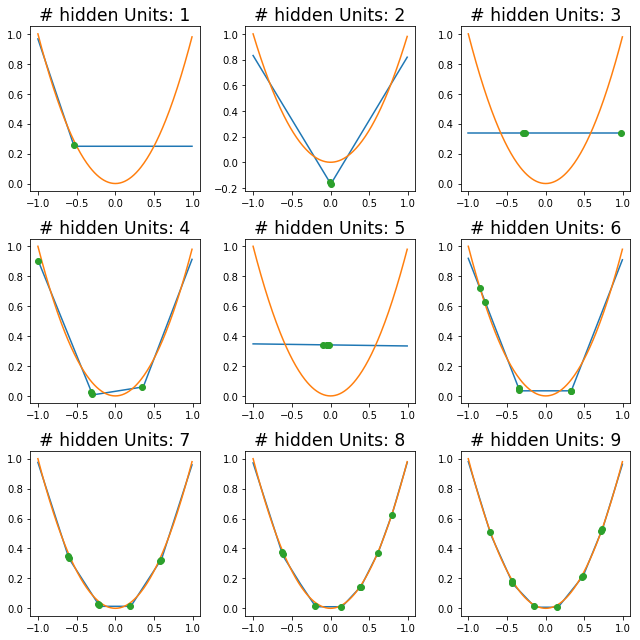

In [15]:
plot_models(models, coeffs)

### Experiment 3
Target function:
$$f(x) = 0.1 + 0.2x + 0.3x^2 + 0.4x^3 + 0.5x^4$$ 

Model:
- Single layer neural network with between 1 and 9 hidden units

In [17]:
coeffs = [0.1, 0.2, 0.3, 0.4, 0.5]

In [19]:
%time models = train_models(coeffs)

1, 2, 3, 4, 5, 6, 7, 8, 9, CPU times: user 16.5 s, sys: 307 ms, total: 16.8 s
Wall time: 51.1 s


1, 2, 3, 4, 5, 6, 7, 8, 9, 

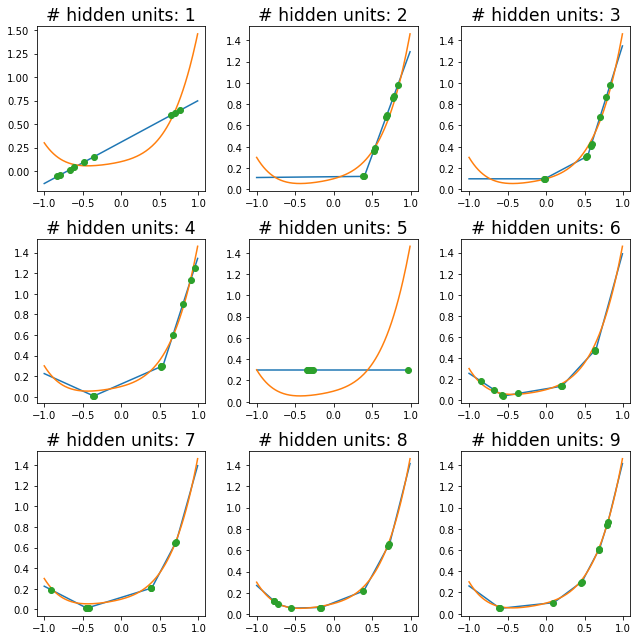

In [31]:
plot_models(models, coeffs)

# Dig a little deeper
$$f(x) = 0.1 + 0.2x + 0.3x^2 + 0.4x^3$$

In [93]:
coeffs = [0.1, 0.2, 0.3, 0.4]
num_hidden_units = 8
model = train_a_model(num_hidden_units, coeffs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 9         
Total params: 25.0
Trainable params: 25.0
Non-trainable params: 0.0
_________________________________________________________________


### Plot target f(x) vs. neural network.

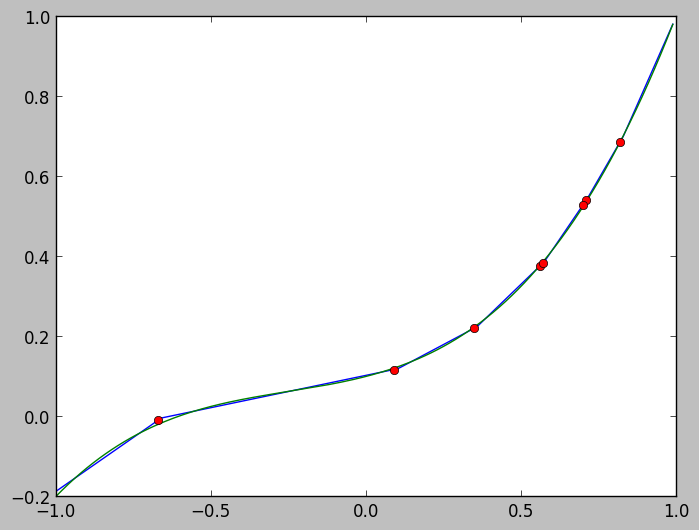

In [94]:
fig = plt.figure()
ax = plt.gca()
plot_a_model(ax, model, coeffs)

In [95]:
hidden_weights = model.layers[1].get_weights()
output_weights = model.layers[2].get_weights()

In [96]:
hidden_weights

[array([[ 0.78695482, -0.5064761 , -0.60523343,  0.61376745, -0.72515196,
          0.84483153,  1.00341153, -0.05368324]], dtype=float32),
 array([-0.65251827,  0.36195171, -0.39972776, -0.35317802,  0.07966564,
        -0.30252522, -0.10766896, -0.09456973], dtype=float32)]

In [97]:
output_weights[0]

array([[ 0.52990729],
       [ 0.39130419],
       [-0.62485725],
       [ 0.63800162],
       [-0.4961434 ],
       [ 0.39837518],
       [ 0.60752338],
       [-0.48757154]], dtype=float32)

### Plot each neuron individually as well as together

In [98]:
def relu(x):
    return np.maximum(x, 0)

## Each suplot shows output from hidden ReLU

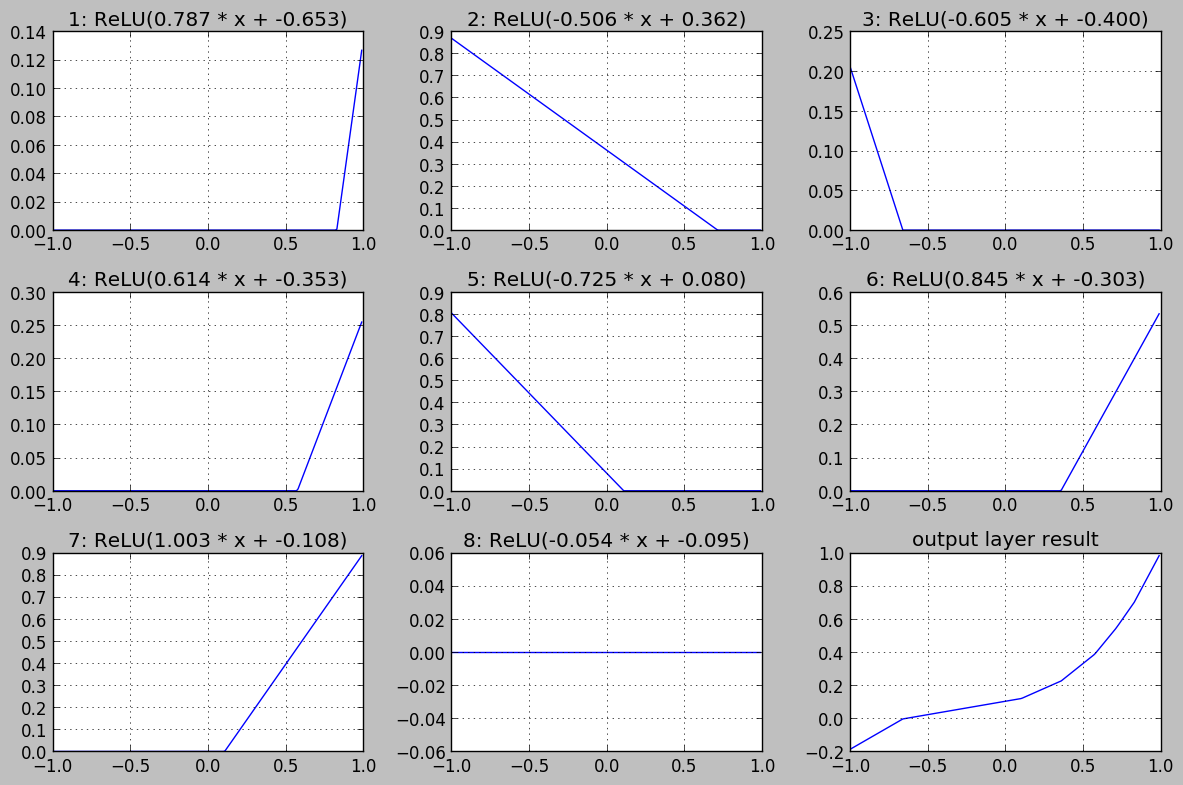

In [99]:
fig, axarr = plt.subplots(3, 3, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
relu_total = 0
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    vals = relu(hidden_w * xs + hidden_b)
    
    ax.plot(xs, vals)
    ax.set_title('{0}: ReLU({1:.3f} * x + {2:.3f})'.format(i + 1, hidden_w, hidden_b))
    ax.grid()

    output_w = output_weights[0][i][0]
    relu_total += output_w * vals

# There is only a single output bias value as there is only a single output neuron
output_b = output_weights[1][0]
relu_total += output_b

last_ax.plot(xs, relu_total)
last_ax.grid()
last_ax.set_title('output layer result')

plt.tight_layout()

## Each suplot shows output from hidden ReLU * output_layer_weight

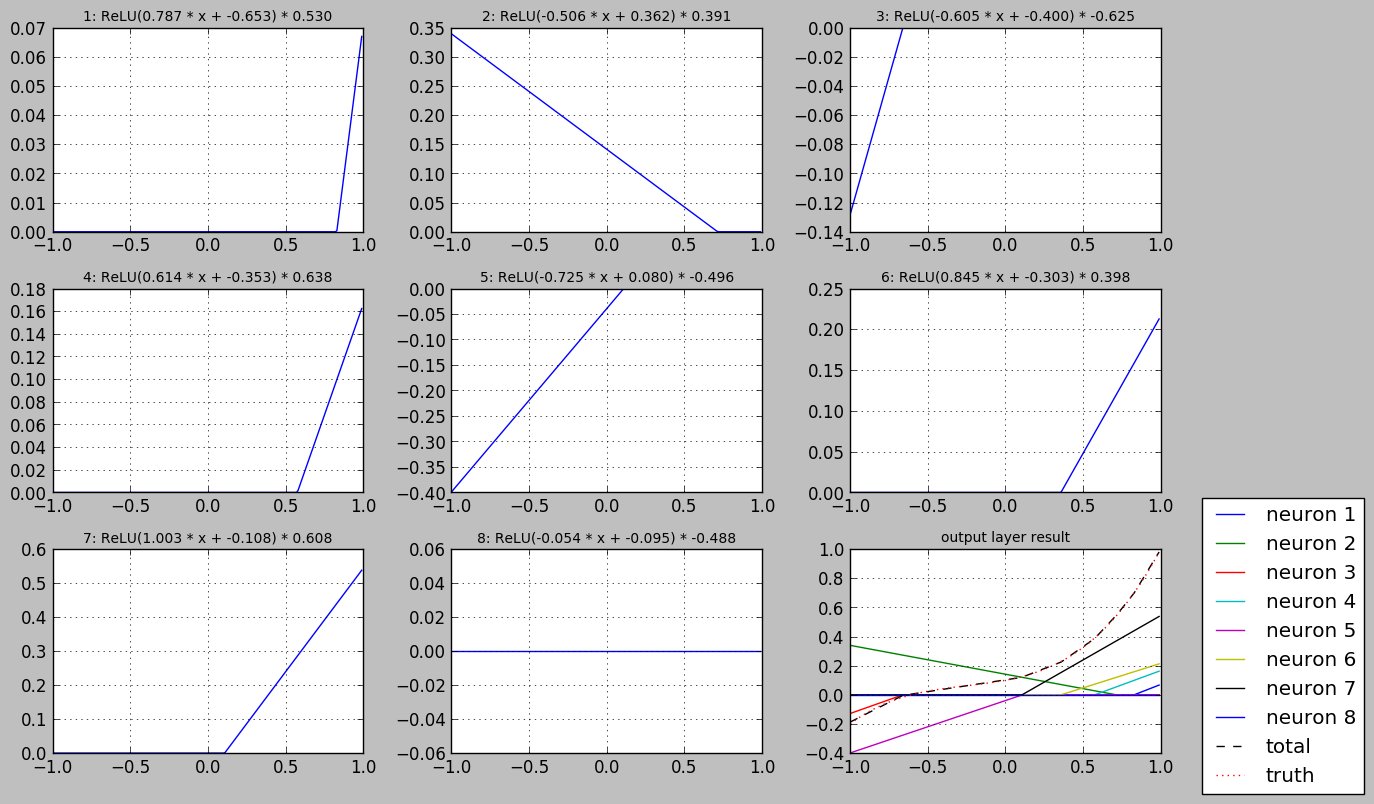

In [100]:
fig, axarr = plt.subplots(3, 3, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
relu_total = 0
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    output_w = output_weights[0][i][0]
    vals = relu(hidden_w * xs + hidden_b) * output_w
    
    ax.plot(xs, vals)
    last_ax.plot(xs, vals, label='neuron {0}'.format(i + 1))
    ax.set_title('{0}: ReLU({1:.3f} * x + {2:.3f}) * {3:.3f}'.format(i + 1, hidden_w, hidden_b, output_w),
                 fontsize=10)
    ax.grid()

    relu_total += vals

# There is only a single output bias value as there is only a single output neuron
output_b = output_weights[1][0]
relu_total += output_b

last_ax.plot(xs, relu_total, '--', color='black', label='total')
ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
last_ax.plot(xs, ys_true, ':', color='red', label='truth')
last_ax.grid()
last_ax.set_title('output layer result', fontsize=10)
last_ax.legend(loc="upper left", bbox_to_anchor=(1.1,1.3))

plt.tight_layout()

#### So at least in 1D, nonlinear functions can be approximated by stacking weighted relu outputs given enough hidden neurons.

# Try another function

An interesting experiment above that might be simple enough to gain some inuition is the 4 neuron network attempting to fit $$f(x) = x^2$$

In [101]:
coeffs = [0, 0, 1]
num_hidden_units = 8
model = train_a_model(num_hidden_units, coeffs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 25.0
Trainable params: 25.0
Non-trainable params: 0.0
_________________________________________________________________


### Plot target f(x) vs. neural network.

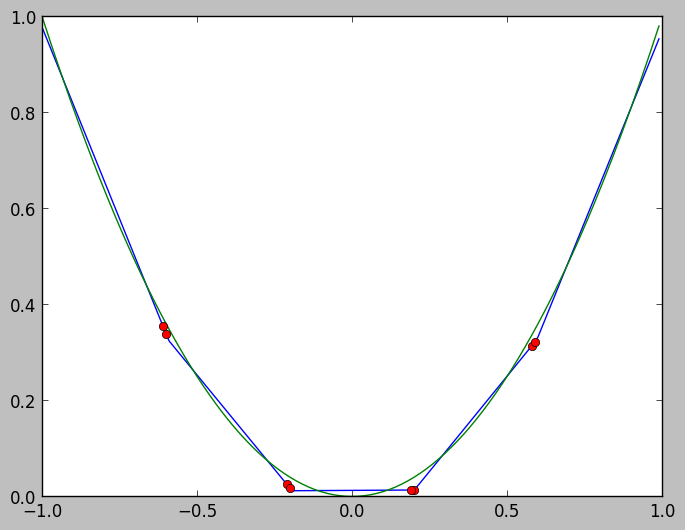

In [102]:
fig = plt.figure()
ax = plt.gca()
plot_a_model(ax, model, coeffs)

In [103]:
hidden_weights = model.layers[1].get_weights()
output_weights = model.layers[2].get_weights()

In [104]:
hidden_weights

[array([[ 0.88950235, -0.09985614,  0.67821676,  0.84828782, -0.14464657,
          1.37594616, -0.17716821, -1.18499017]], dtype=float32),
 array([ 0.17199232, -0.11335748, -0.13625376, -0.50599104, -0.20890762,
         0.81725818, -0.1831117 , -0.70203543], dtype=float32)]

In [105]:
output_weights[0]

array([[ 0.88817692],
       [ 0.07567776],
       [ 1.16336679],
       [ 0.94175708],
       [-0.6041469 ],
       [-0.57147986],
       [-0.00962379],
       [ 1.34732807]], dtype=float32)

### Plot each neuron individually as well as together

In [106]:
def relu(x):
    return np.maximum(x, 0)

## Each suplot shows output from hidden ReLU

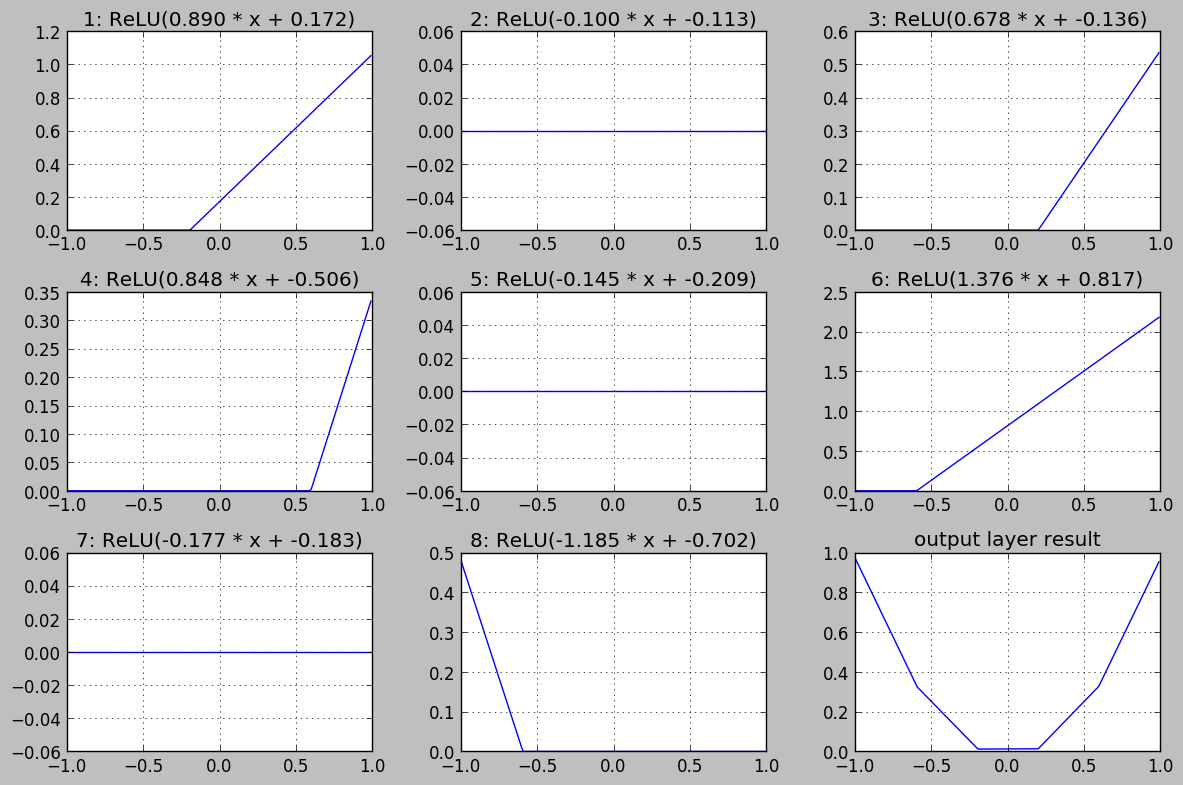

In [107]:
fig, axarr = plt.subplots(3, 3, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
relu_total = 0
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    vals = relu(hidden_w * xs + hidden_b)
    
    ax.plot(xs, vals)
    ax.set_title('{0}: ReLU({1:.3f} * x + {2:.3f})'.format(i + 1, hidden_w, hidden_b))
    ax.grid()

    output_w = output_weights[0][i][0]
    relu_total += output_w * vals

# There is only a single output bias value as there is only a single output neuron
output_b = output_weights[1][0]
relu_total += output_b

last_ax.plot(xs, relu_total)
last_ax.grid()
last_ax.set_title('output layer result')

plt.tight_layout()

## Each suplot shows output from hidden ReLU * output_layer_weight

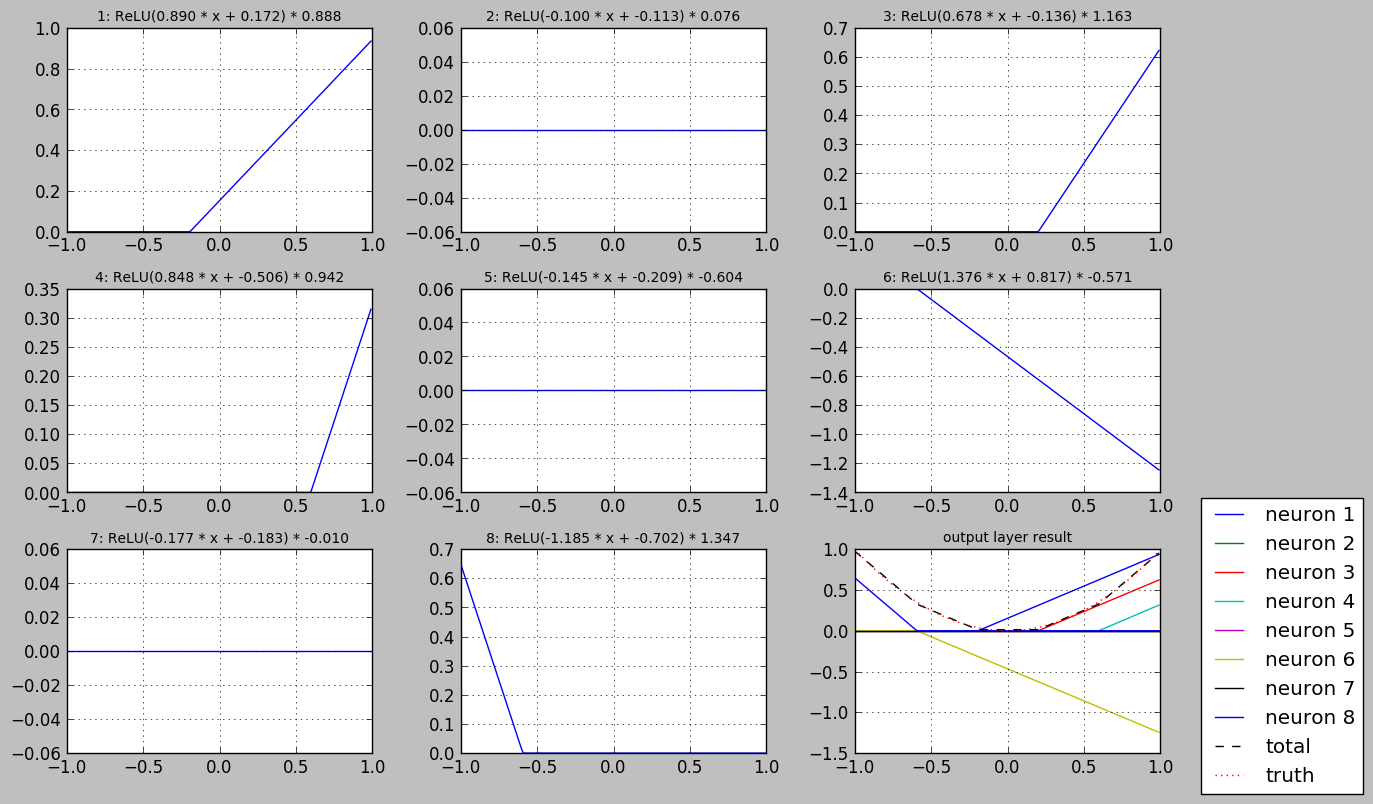

In [108]:
fig, axarr = plt.subplots(3, 3, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
relu_total = 0
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    output_w = output_weights[0][i][0]
    vals = relu(hidden_w * xs + hidden_b) * output_w
    
    ax.plot(xs, vals)
    last_ax.plot(xs, vals, label='neuron {0}'.format(i + 1))
    ax.set_title('{0}: ReLU({1:.3f} * x + {2:.3f}) * {3:.3f}'.format(i + 1, hidden_w, hidden_b, output_w),
                 fontsize=10)
    ax.grid()

    relu_total += vals

# There is only a single output bias value as there is only a single output neuron
output_b = output_weights[1][0]
relu_total += output_b

last_ax.plot(xs, relu_total, '--', color='black', label='total')
ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
last_ax.plot(xs, ys_true, ':', color='red', label='truth')
last_ax.grid()
last_ax.set_title('output layer result', fontsize=10)
last_ax.legend(loc="upper left", bbox_to_anchor=(1.1,1.3))

plt.tight_layout()

#### So

1. Indeed there should be about 9 kinks resulting from overlapping 9 plots, assuming each line has one kink (i.e. non-linearity of ReLU).

2. Repeating the experiments may produce hidden neurons with different weights and bias while their linear combination results in similar shape, which explains why multiple different NNs have similar performances (local minima!).

# Try a more complex function from http://neuralnetworksanddeeplearning.com/chap4.html (todo)

$$f(x) = 0.2 + 0.4 x^2 + 0.3 sin(15x) + 0.05 cos(50x)$$

In [4]:
def cust_generator(coeffs, batch_size=320):
    output_x = np.zeros((batch_size))
    output_y = np.zeros((batch_size))
       
    while True:
        output_x = np.random.uniform(-1.0, 1.0, batch_size)
        output_y = np.polynomial.polynomial.polyval(output_x, coeffs)
        yield output_x, output_y

In [5]:
def train_a_model(num_hidden_units, coeffs):
    model = get_model(num_hidden_units)
    generator = poly_generator(coeffs)
    model.fit_generator(generator, steps_per_epoch=1000, epochs=1, verbose=0)
    return model

In [ ]:
def train_a_model(num_hidden_units, coeffs):
    model = get_model(num_hidden_units)
    generator = poly_generator(coeffs)
    model.fit_generator(generator, steps_per_epoch=1000, epochs=1, verbose=0)
    return model